Imports

In [8]:
import joblib
import numpy as np
import tensorflow as tf
from collections import Counter

import sys
import os
import random
import math
import random
import multiprocessing as mp
import gc
import time
import datetime

from tensorflow.keras import datasets, layers, models

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from etl_data_reader.etl_data_reader import ETL_data_reader
from etl_data_reader.etl_data_names import ETL_data_names
from etl_data_reader.etl_character_groups import ETL_character_groups

from sklearn.preprocessing import LabelBinarizer

# Change matplotlib to use a Japanese font
# to actually be able to display correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)

Global variables, used throughout the program

In [2]:
debug = True
num_chars = 759  #759 per part.pkl
epochs = 150

#Set the path for input data and create the reader
path = "./ETL_kanji"
reader = ETL_data_reader(path)

In [3]:
# Debug method to see if images are loading correctly
def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

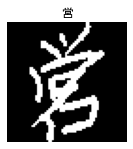

In [4]:
if debug:
    sample_img, sample_lable = reader.read_dataset_file(1, ETL_data_names.ETL10, ETL_character_groups.all)
    show_image(sample_img[200], sample_lable[200])
    # free again
    del(sample_img)
    del(sample_lable)

## Load the data
Grab all the data from ETL9B (ETL10) and shuffle it

In [5]:
x, y =  reader.read_dataset_part(ETL_data_names.ETL10, ETL_character_groups.kanji)    # load only the relevant dataset
#x, y = reader.read_dataset_whole([ETL_character_groups.kanji], 16)
print(x.shape, y.shape)

# because the data is ordered shuffle it
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(y)

Loading all data set files (ETL10_x) from: ./ETL_kanji\ETL10...
(595965, 64, 64, 1) (595965,)


One-hot-encode the labels for the CNN, save the labels for later use

In [9]:
#one hot encode the labels
lb = LabelBinarizer()
lb.fit(y)
o_y = lb.transform(y)

# free the memory from the original string labels
del(y)

# concat classes-list to string
classes = [i for i in lb.classes_]
s = "".join([i for i in lb.classes_])

# save a list of all labels into a .txt file
with open("./labels.txt", "w+", encoding="utf8") as f:
    f.write(s)
    
# a string formatted as a python list can be easily evaluated 
# therefore lets save this representation too
with open("./labels_python_list.txt", "w+", encoding="utf8") as f:
    f.write(str(classes))

In [10]:
# store the images in a shared array and free the loaded data
memory_size_x = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
x_shared = mp.RawArray("f", memory_size_x // 2)
x_np = np.frombuffer(x_shared, dtype="float16").reshape(x.shape)
np.copyto(x_np, x)
del(x)

# store the labels in a shared array and free the loaded data
memory_size_y = o_y.shape[0] * o_y.shape[1]
y_shared = mp.RawArray('b', memory_size_y)
y_np = np.frombuffer(y_shared, dtype="b").reshape(o_y.shape)
np.copyto(y_np, o_y)
del(o_y)

gc.collect()

if debug:
    show_image(x_np[200], lb.inverse_transform(np.array([y_np[200]])))

NameError: name 'mp' is not defined

Load data, print some for verification

In [ ]:
'''
#data = joblib.load(f'{base_name}_{width}x{width}px.pkl.part1')
data = joblib.load('./Input/all_characters_64x64px.pkl.part1')

if debug:
    print('Number of samples: ', len(data['data']))
    print('keys: ', list(data.keys()))
    print('description: ', data['description'])
    print('image shape: ', data['data'][0].shape)
    print('labels:', np.unique(data['label']))

    #Counter(data['label'])


    plt.figure(figsize=(10,10))
    for i in range(25):
        index = random.randint(0, len(data['data']) - 1)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data['data'][index], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(data['label'][index])
    plt.show()
'''

Split data into training and test

In [ ]:
from sklearn.model_selection import train_test_split

#X = np.array(data['data'])
#y = np.array(data['label'])

n_samples = len(data['data'])


X_train, X_test, y_train, y_test = train_test_split(
    np.array(data['data'][:num_chars*200]),
    np.array(data['label'][:num_chars*200]),
    test_size=0.2,
    shuffle=True,
    random_state=42)

del data

X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)

print(f'X_test: {len(X_test)}, X_train: {len(X_train)}')



Change labels from strings to numbers so tensorflow can use them

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

Create the model

In [ ]:
model = models.Sequential()

'''
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
'''

'''
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))



model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.25))


model.add(layers.Dense(num_chars))
'''

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(input_shape=(64, 64, 1), kernel_size=3, activation='relu', filters=32, name="conv2D_1_2_input"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_1_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_1_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_1"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_2_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_2_2"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2D_3_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2D_3_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_3"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=128, name="conv2D_4_1"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_4"),

        tf.keras.layers.Flatten(name="flatten_1"),
        tf.keras.layers.Dropout(0.25, name="dropout_1"),
        
        tf.keras.layers.Dense(2048, name="dense_1"),
        tf.keras.layers.Dropout(0.1, name="dropout_2"),
        tf.keras.layers.Dense(2048, name="densfasave_1"),
        tf.keras.layers.Dropout(0.1, name="dropourstat_2"),

        tf.keras.layers.Dense(2048, name="dense_2"),
        tf.keras.layers.Dropout(0.25, name="dropout_3"),
        tf.keras.layers.Dense(2048, name="densearst_2"),
        tf.keras.layers.Dropout(0.25, name="dropouart_3"),

        tf.keras.layers.Dense(num_chars, name="dense_3"),

        #set the dtype to float32 for numerical stability
        tf.keras.layers.Softmax(dtype="float32", name="softmax_1_output") 
    ], name="model")

if debug:
    model.summary()

Train the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))

Display model information

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

In [ ]:
debug = False

if debug:
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test
    
    #y_pred = le.inverse_transform(y_pred)
    #y_true = le.inverse_transform(y_test)

    labels = np.unique(le.inverse_transform(y_test))

    conf_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(100, 80))
    sns.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
